In [1]:
# %pip install gradio==3.47 --quiet
# %pip install clip_retrieval --quiet
# %pip install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu118
# %pip install diffusers --quiet
# %pip install accelerate --quiet

In [2]:
import warnings
warnings.filterwarnings('ignore')

import requests
import gradio as gr
from io import BytesIO
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

import torch
from tqdm.auto import tqdm
from transformers import CLIPTextModel, CLIPTokenizer
from clip_retrieval.clip_client import ClipClient, Modality
from diffusers import AutoencoderKL, UNet2DConditionModel, LCMScheduler, LMSDiscreteScheduler

torch_device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
HF_ACCESS_TOKEN = "" # Add your HuggingFace access token

In [3]:
model_path = "/home/akameswa/research/models/tiny-sd"                          # Huggingface model path
imageHeight, imageWidth = 512, 512                                             # Image size
guidance_scale = 8                                                             # Guidance scale

tokenizer = CLIPTokenizer.from_pretrained("openai/clip-vit-large-patch14")
text_encoder = CLIPTextModel.from_pretrained("openai/clip-vit-large-patch14").to(torch_device)
scheduler = LMSDiscreteScheduler.from_pretrained(model_path, subfolder="scheduler")
unet = UNet2DConditionModel.from_pretrained(model_path, subfolder="unet").to(torch_device)
vae = AutoencoderKL.from_pretrained(model_path, subfolder="vae").to(torch_device)

In [4]:
def get_text_embeddings(prompt, tokenizer=tokenizer, text_encoder=text_encoder, torch_device=torch_device, batch_size=1):
    text_input = tokenizer(prompt, padding="max_length", max_length=tokenizer.model_max_length, truncation=True, return_tensors="pt")
    
    with torch.no_grad():
        text_embeddings = text_encoder(text_input.input_ids.to(torch_device))[0]
    max_length = text_input.input_ids.shape[-1]
    uncond_input = tokenizer(
        [""] * batch_size, padding="max_length", max_length=max_length, return_tensors="pt"
    )
    with torch.no_grad():
        uncond_embeddings = text_encoder(uncond_input.input_ids.to(torch_device))[0]   
    text_embeddings = torch.cat([uncond_embeddings, text_embeddings])
    
    return text_embeddings

In [5]:
def generate_latents(seed, height=imageHeight, width=imageWidth, torch_device=torch_device, unet=unet, batch_size=1):
    generator = torch.Generator().manual_seed(int(seed))
    
    latents = torch.randn(
      (batch_size, unet.config.in_channels, height // 8, width // 8),
      generator=generator,
    ).to(torch_device)

    return latents

In [6]:
def generate_modified_latents(pokeX, pokeY, seed, pokeHeight, pokeWidth, imageHeight=imageHeight, imageWidth=imageWidth):
    original_latents = generate_latents(seed, height=imageHeight, width=imageWidth)
    poke_latents = generate_latents(seed, height=pokeHeight, width=pokeWidth)

    x_origin = pokeX // 8 - poke_latents.shape[2] // 2          
    y_origin = pokeY // 8 - poke_latents.shape[3] // 2

    modified_latents = original_latents.clone()
    modified_latents[:,:,x_origin:x_origin+poke_latents.shape[2],y_origin:y_origin+poke_latents.shape[3]] = poke_latents

    return original_latents, modified_latents

In [7]:
def convert_to_pil_image(image):
    image = (image / 2 + 0.5).clamp(0, 1)
    image = image.detach().cpu().permute(0, 2, 3, 1).numpy()
    images = (image * 255).round().astype("uint8")
    pil_images = [Image.fromarray(image) for image in images]
    return pil_images[0]

In [8]:
def generate_images(latents, text_embeddings, num_inference_steps, unet=unet, guidance_scale=guidance_scale, vae=vae, scheduler=scheduler, intermediate=False):
    scheduler.set_timesteps(num_inference_steps)
    latents = latents * scheduler.init_noise_sigma
    images = []
    
    for t in tqdm(scheduler.timesteps):
        latent_model_input = torch.cat([latents] * 2)
        latent_model_input = scheduler.scale_model_input(latent_model_input, t)

        with torch.no_grad():
            noise_pred = unet(latent_model_input, t, encoder_hidden_states=text_embeddings).sample

        noise_pred_uncond, noise_pred_text = noise_pred.chunk(2)
        noise_pred = noise_pred_uncond + guidance_scale * (noise_pred_text - noise_pred_uncond)

        latents = scheduler.step(noise_pred, t, latents).prev_sample
        
        if intermediate:
            Latents = 1 / 0.18215 * latents
            with torch.no_grad():
                image = vae.decode(Latents).sample
            images.append(convert_to_pil_image(image))

    if not intermediate:
        Latents = 1 / 0.18215 * latents
        with torch.no_grad():
            image = vae.decode(Latents).sample
        images = convert_to_pil_image(image)

    return images

# Poking latent space

The objective is to understand how a poke at the initial noise influences the image generation of diffusion models.

In [9]:
def visualize_poke(pokeX, pokeY, pokeHeight, pokeWidth, imageHeight=imageHeight, imageWidth=imageWidth):
    if pokeX - pokeWidth // 2 < 0 or pokeX + pokeWidth // 2 > imageWidth or pokeY - pokeHeight // 2 < 0 or pokeY + pokeHeight // 2 > imageHeight:
        gr.Warning("Error: Poking region outside image")
    shape = [(pokeX - pokeWidth // 2, pokeY - pokeHeight // 2), (pokeX + pokeWidth // 2, pokeY + pokeHeight // 2)] 
    img = Image.new("RGB", (imageHeight, imageWidth))
    rec = ImageDraw.Draw(img) 
    rec.rectangle(shape, outline ="white") 
    return img

In [10]:
def display_images(prompt, pokeX, pokeY, heightPoke, widthPoke, seed, num_inference_steps, poke=False, intermediate=False):
    text_embeddings = get_text_embeddings(prompt)
    latents, modified_latents = generate_modified_latents(pokeX, pokeY, seed, heightPoke, widthPoke)
    images = generate_images(latents, text_embeddings, num_inference_steps, intermediate=intermediate)

    if poke: modImages = generate_images(modified_latents, text_embeddings, num_inference_steps, intermediate=intermediate)
    else:    modImages = None
    
    return images, modImages

# Setting the parameters

In [11]:
prompt = "dog in car"
num_inference_steps = 20            # 20+ for good results
seed = 69420                        # Any integer

poke = True                         # Set true if you want to poke
intermediate = True                 # Set true if you want to see intermediate images
pokeX, pokeY = 256, 256             # Poke coordinates
pokeHeight, pokeWidth = 128, 128    # Poke size

In [12]:
if pokeX - pokeWidth // 2 < 0 or pokeX + pokeWidth // 2 > imageWidth or pokeY - pokeHeight // 2 < 0 or pokeY + pokeHeight // 2 > imageHeight:
    print("Error: Poking region outside image")

# Visualizing poke and the generated images

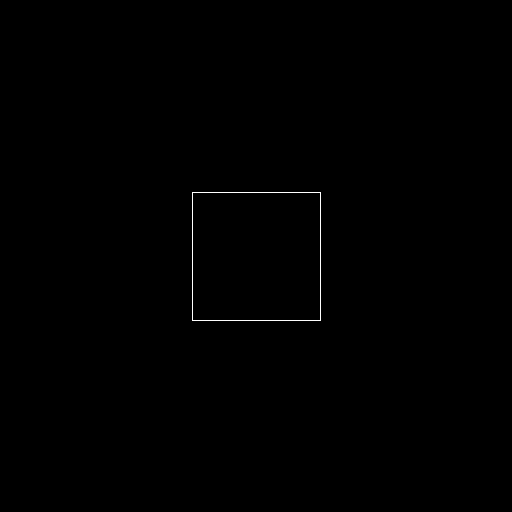

In [13]:
visualize_poke(pokeX, pokeY, pokeHeight, pokeWidth)

In [14]:
images, modImages = display_images(prompt, pokeX, pokeY, pokeHeight, pokeWidth, seed, num_inference_steps, poke, intermediate)

 80%|████████  | 16/20 [00:08<00:01,  2.11it/s]

100%|██████████| 20/20 [00:09<00:00,  2.10it/s]


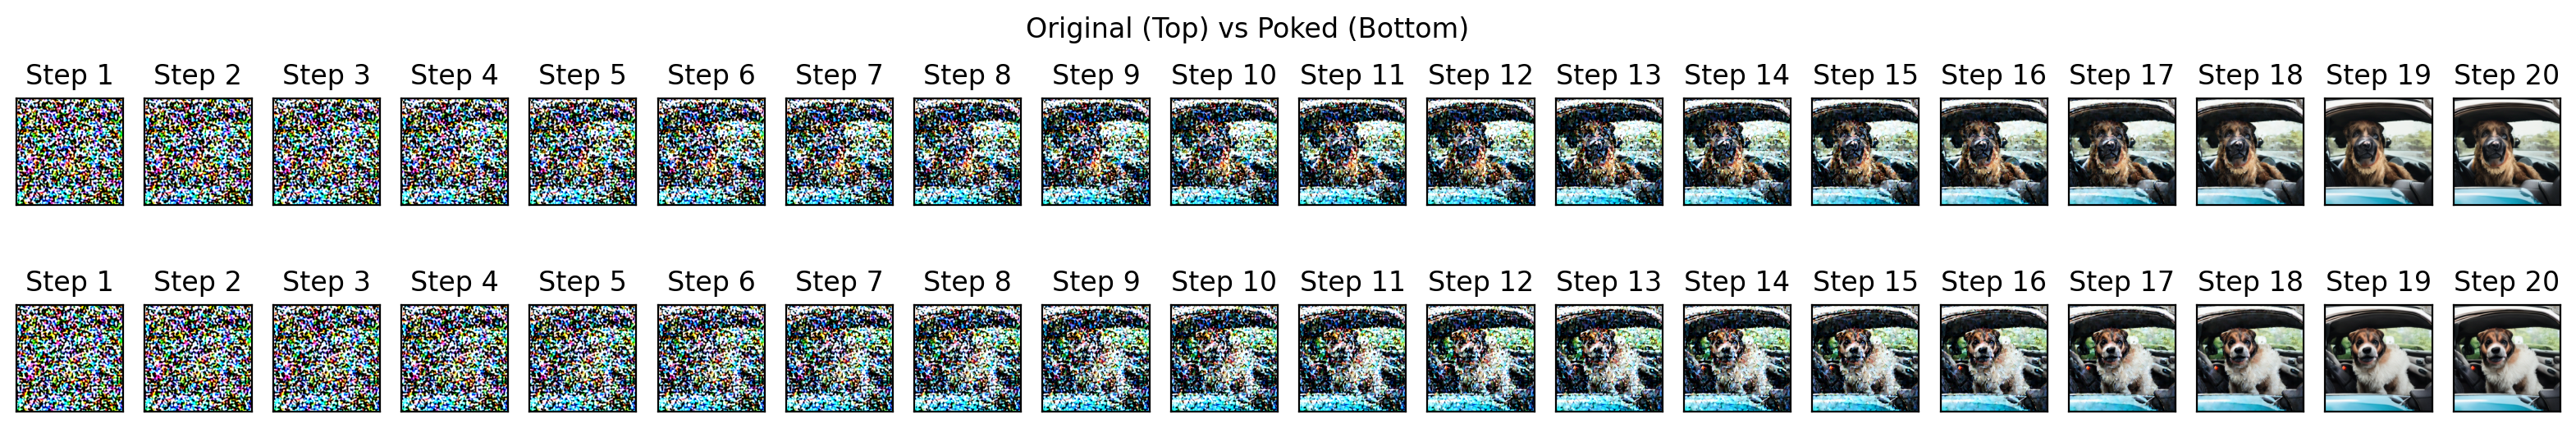

In [15]:
if poke:
    if intermediate:
        fig, ax = plt.subplots(2, num_inference_steps, dpi=200, figsize=(num_inference_steps, 3))
        fig.suptitle("Original (Top) vs Poked (Bottom)")

        for i in range(num_inference_steps):
            ax[0][i].set_title(f"Step {i+1}")
            ax[0][i].imshow(images[i])
            ax[0][i].set_xticks([])
            ax[0][i].set_yticks([])

            ax[1][i].set_title(f"Step {i+1}")
            ax[1][i].imshow(modImages[i])
            ax[1][i].set_xticks([])
            ax[1][i].set_yticks([])

    else:
        fig, ax = plt.subplots(2, 1, dpi=200, figsize=(1, 2))
        fig.suptitle("Original (Top) vs Poked (Bottom)")
        ax[0].imshow(images)
        ax[0].set_xticks([])
        ax[0].set_yticks([])

        ax[1].imshow(modImages)
        ax[1].set_xticks([])
        ax[1].set_yticks([])
else:
    if intermediate:    
        fig, ax = plt.subplots(1, num_inference_steps, dpi=200, figsize=(num_inference_steps, 2))
        fig.suptitle("Images")
        for i in range(num_inference_steps):
            ax[i].set_title(f"Step {i+1}")
            ax[i].imshow(images[i])
            ax[i].set_xticks([])
            ax[i].set_yticks([])
    else:
        fig, ax = plt.subplots(1, 1, dpi=200, figsize=(2,2))
        fig.suptitle("Image")
        ax.imshow(images)
        ax.set_xticks([])
        ax.set_yticks([])

plt.show()

# Prompt Interpolation

The objective is to understand the image generation in between two prompts 

In [16]:
def interpolate_prompts(promptA, promptB, num_interpolation_steps):
    text_embeddingsA = get_text_embeddings(promptA)
    text_embeddingsB = get_text_embeddings(promptB)

    interpolated_embeddings = []
    
    for i in range(num_interpolation_steps):
        alpha = i / num_interpolation_steps
        interpolated_embedding = torch.lerp(text_embeddingsA, text_embeddingsB, alpha)
        interpolated_embeddings.append(interpolated_embedding)

    return interpolated_embeddings

In [17]:
def display_prompt_images(seed, promptA, promptB, num_inference_steps, num_images):
    latents = generate_latents(seed)
    text_embeddings = interpolate_prompts(promptA, promptB, num_images)
    images = []
    for i in range(num_images):   
        image = generate_images(latents, text_embeddings[i], num_inference_steps)
        images.append((image,i+1))
        
    return images

In [18]:
promptA = "a car driving on a highway in a city"
promptB = "a truck driving on a highway in a city"

num_images = 5                      # Number of images to generate
num_inference_steps = 20            # 20+ for good results
seed = 69420                        # Any integer

In [19]:
images = display_prompt_images(seed, promptA, promptB, num_inference_steps, num_images)

100%|██████████| 20/20 [00:03<00:00,  5.72it/s]


100%|██████████| 20/20 [00:03<00:00,  5.68it/s]


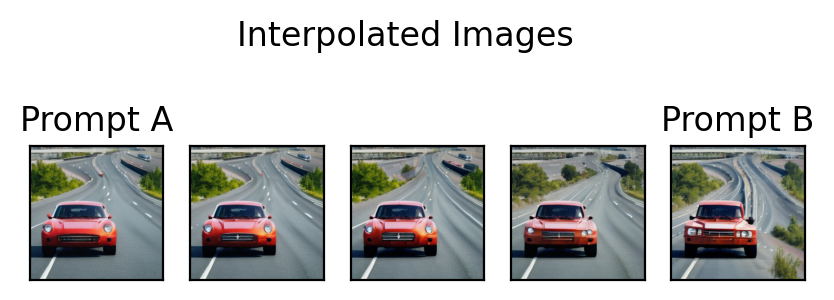

In [20]:
fig, ax = plt.subplots(1, num_images, dpi=200, figsize=(num_images, 2))
fig.suptitle("Interpolated Images")

for i in range(num_images):
    ax[i].imshow(images[i][0])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

ax[0].set_title("Prompt A")
ax[num_images-1].set_title("Prompt B") 

plt.show()

# Similar Image Generation

In [21]:
def display_similar_images(prompt, seed, num_inference_steps, num_images, differentiation):
    text_embeddings = get_text_embeddings(prompt)

    latents_x = generate_latents(seed)
    latents_y = generate_latents(seed*180)

    scale_x = torch.cos(torch.linspace(0, 1, 10)*2*torch.pi*differentiation).to(torch_device)
    scale_y = torch.sin(torch.linspace(0, 1, 10)*2*torch.pi*differentiation).to(torch_device)

    noise_x = torch.tensordot(scale_x, latents_x, dims=0)
    noise_y = torch.tensordot(scale_y, latents_y, dims=0)

    noise = noise_x + noise_y
    batched_noise = torch.split(noise, num_images)

    images = []
    for i in range(num_images):   
        image = generate_images(batched_noise[0][i], text_embeddings, num_inference_steps)
        images.append((image,i+1))

    return images   

In [22]:
prompt = "red balloon in the sky"
num_images = 5                      # Number of images to generate
differentiation = 0.1               # Differentiation factor
num_inference_steps = 20            # 20+ for good results
seed = 69420                        # Any integer

In [23]:
images = display_similar_images(prompt, seed, num_inference_steps, num_images, differentiation)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [00:03<00:00,  5.62it/s]


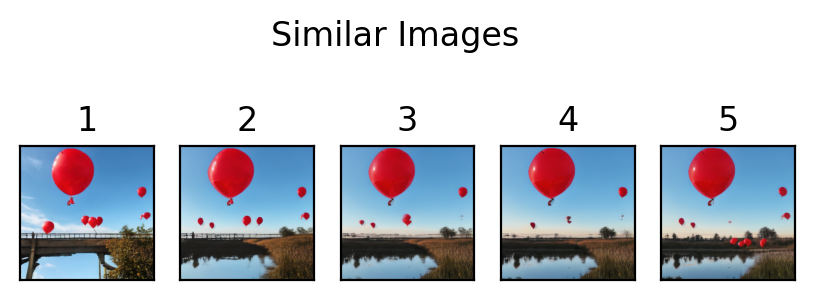

In [24]:
fig, ax = plt.subplots(1, num_images, dpi=200, figsize=(num_images, 2))
fig.suptitle("Similar Images")

for i in range(num_images):
    ax[i].imshow(images[i][0])
    ax[i].set_title(images[i][1])
    ax[i].set_xticks([])
    ax[i].set_yticks([])

plt.show()

# Peek into training dataset

In [25]:
prompt = "cat"        

In [26]:
def retrieve_images(prompt):
    client = ClipClient(
        url="https://knn.laion.ai/knn-service",
        indice_name="laion5B-L-14",
        aesthetic_score=9,
        aesthetic_weight=0.5,
        modality=Modality.IMAGE,
        num_images=10,
    )
    results = client.query(text=prompt)
    image_captions = []
    for result in results:
        caption, url = result["caption"], result["url"]
        try:
            response = requests.get(url)
            image = Image.open(BytesIO(response.content))
            image_captions.append((image, caption))
        except:
            pass
    return image_captions

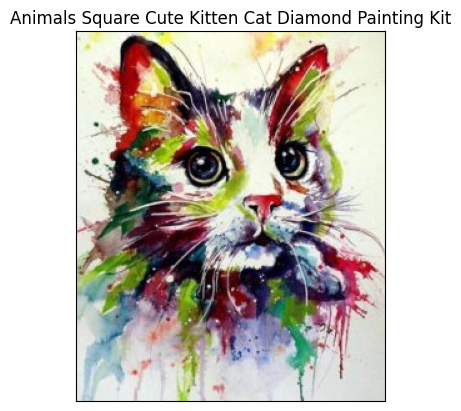

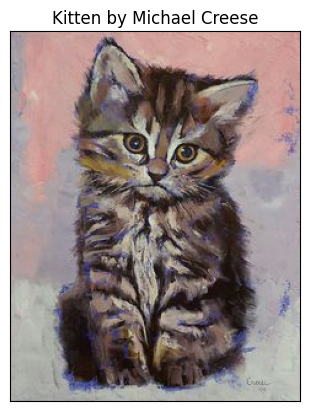

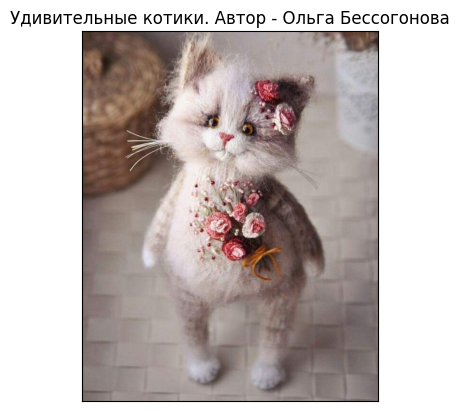

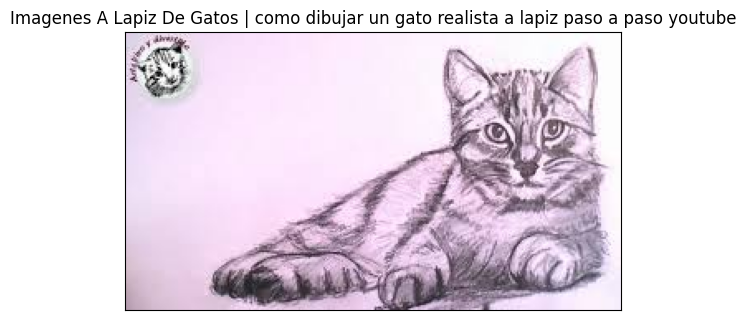

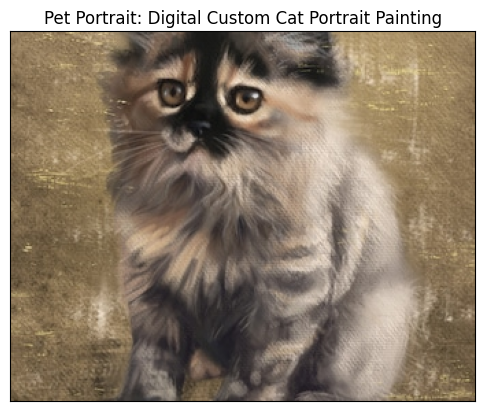

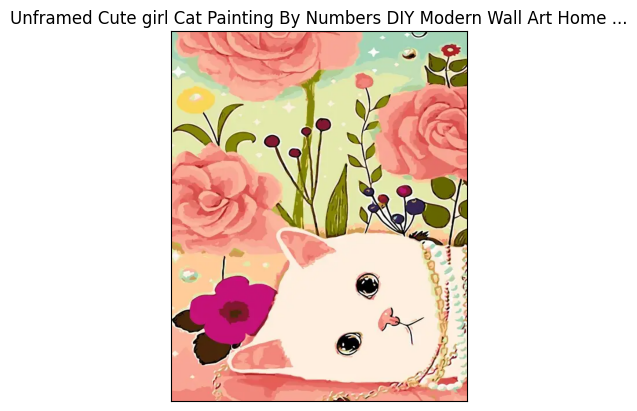

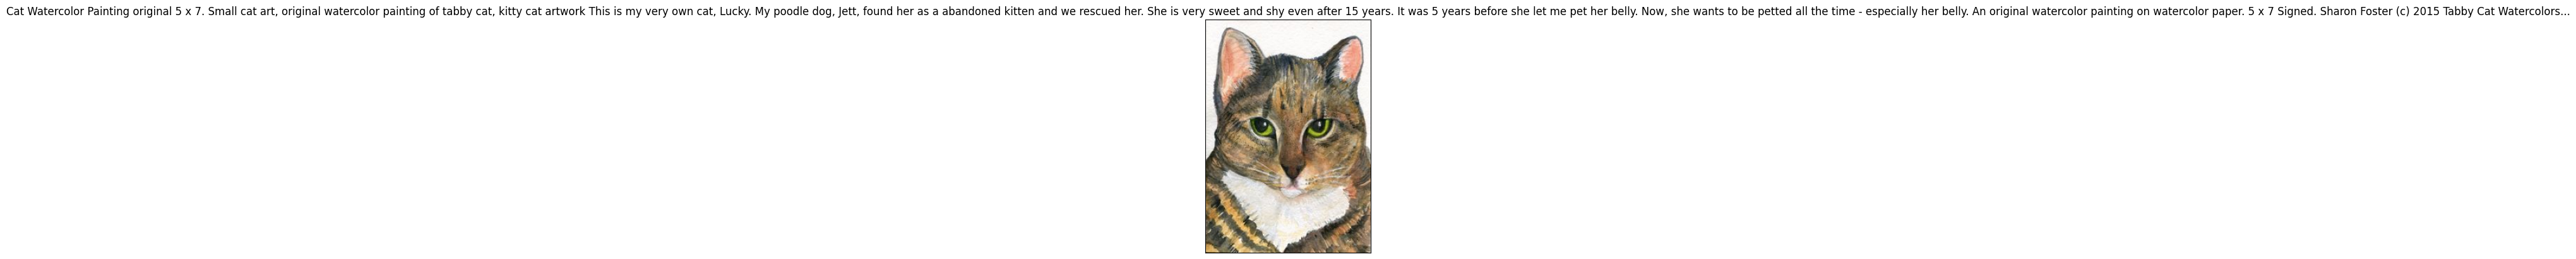

In [27]:
images = retrieve_images(prompt)

for i in range(len(images)):
    plt.imshow(images[i][0])
    plt.title(images[i][1])
    plt.xticks([])
    plt.yticks([])
    plt.show()

# Demo

In [28]:
with gr.Blocks() as demo:
    gr.Markdown("## Stable Diffusion Demo")
    with gr.Tab("PokE"):
        with gr.Row():
            with gr.Column():
                pokeX = gr.Slider(label="pokeX", minimum=0, maximum=imageWidth, step=1, value=256, info= "X coordinate of poke center")
                pokeY = gr.Slider(label="pokeY", minimum=0, maximum=imageHeight, step=1, value=256, info= "Y coordinate of poke center")
                pokeHeight = gr.Slider(label="pokeHeight", minimum=0, maximum=imageHeight, step=8, value=128, info= "Height of the poke")
                pokeWidth = gr.Slider(label="pokeWidth", minimum=0, maximum=imageWidth, step=8, value=128, info= "Width of the poke")
                visualize_poke_button = gr.Button("Visualize Poke")

            with gr.Column():
                visualize_poke_output = gr.Image(label="Poke Visualization")
                    
        with gr.Row():
            with gr.Column():
                prompt_0 = gr.Textbox(lines=1, label="Prompt", value="dog in car")
                num_inference_steps_0 = gr.Slider(minimum=0, maximum=100, step=1, value=5, label="Number of Inference Steps per Image")
                seed_0 = gr.Slider(minimum=0, maximum=100, step=1, value=69, label="Seed")
                generate_images_button_0 = gr.Button("Generate Images")
            
            with gr.Column():
                original_images_output_0 = gr.Gallery(label="Original Images", selected_index=0)
                poked_images_output_0 = gr.Gallery(label="Poked Images", selected_index=0)

    with gr.Tab("Prompt Interpolation"):
        with gr.Row():
            with gr.Column():
                promptA = gr.Textbox(lines=1, label="Prompt from", value="car driving on a highway in a city")
                num_images_1 = gr.Slider(minimum=0, maximum=100, step=1, value=5, label="Number of Images")
                num_inference_steps_1 = gr.Slider(minimum=0, maximum=100, step=1, value=8, label="Number of Inference Steps per Image")
                seed_1 = gr.Slider(minimum=0, maximum=100, step=1, value=69, label="Seed")
                
            with gr.Column():
                promptB = gr.Textbox(lines=1, label="Prompt to", value="truck driving on a highway in a city")                
        
        with gr.Row():
            generate_images_button_1 = gr.Button("Generate Images")

        with gr.Row():
            images_output_1 = gr.Gallery(label="Interpolated Images", selected_index=0)

    with gr.Tab("Similar Image Generation"):
        with gr.Row():
            with gr.Column():
                prompt_2 = gr.Textbox(lines=1, label="Prompt", value="dog in car")
                num_images_2 = gr.Slider(minimum=0, maximum=100, step=1, value=5, label="Number of Images")
                differentiation = gr.Slider(minimum=0, maximum=1, step=0.1, value=0.1, label="Differentiation", info="The higher the differentiation, the more different the images will be")
                num_inference_steps_2 = gr.Slider(minimum=0, maximum=100, step=1, value=8, label="Number of Inference Steps per Image")
                seed_2 = gr.Slider(minimum=0, maximum=100, step=1, value=69, label="Seed")
                generate_images_button_2 = gr.Button("Generate Images")

            with gr.Column():
                images_output_2 = gr.Gallery(label="Image", selected_index=0)

    with gr.Tab("Dataset Peek"):
        with gr.Row():
            with gr.Column():
                prompt_3 = gr.Textbox(lines=1, label="Prompt", value="dog")
                retrieve_images_button = gr.Button("Retrieve Images")
                retrieved_images_output = gr.Gallery(label="Image", selected_index=0)
    
    visualize_poke_button.click(fn=visualize_poke, inputs=[pokeX, pokeY, pokeHeight, pokeWidth], outputs=visualize_poke_output)

    @generate_images_button_0.click(inputs=[prompt_0, pokeX, pokeY, pokeHeight, pokeWidth, seed_0, num_inference_steps_0], outputs=[original_images_output_0, poked_images_output_0])
    def generate_images_wrapper(prompt, pokeX, pokeY, pokeHeight, pokeWidth, seed, num_inference_steps):
        images, modImages = display_images(prompt, pokeX, pokeY, pokeHeight, pokeWidth, seed, num_inference_steps, poke=True, intermediate=True)
        return images, modImages
    
    generate_images_button_1.click(fn=display_prompt_images, inputs=[seed_1, promptA, promptB, num_inference_steps_1, num_images_1], outputs=images_output_1)
    generate_images_button_2.click(fn=display_similar_images, inputs=[prompt_2, seed_2, num_inference_steps_2, num_images_2, differentiation], outputs=images_output_2)
    retrieve_images_button.click(fn=retrieve_images, inputs=[prompt_3], outputs=retrieved_images_output)
    
demo.queue()
demo.launch(share=True)

Running on local URL:  http://127.0.0.1:7860
Running on public URL: https://60a7e972e382c60852.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades, run `gradio deploy` from Terminal to deploy to Spaces (https://huggingface.co/spaces)


100%|██████████| 20/20 [00:09<00:00,  2.06it/s]
